<a href="https://colab.research.google.com/github/Fermu25/Cursos/blob/main/ML_Clase20_de_NBKerasTunnerTF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow 2 + Keras Tuner: afinando hiperparámetros para MNIST, claro y reproducible



## Resumen

Un recorrido práctico y reproducible de la afinación de hiperparámetros con TensorFlow 2 y **Keras Tuner**.

Este notebook guía, de principio a fin, la construcción y optimización de un *clasificador de dígitos MNIST* usando TensorFlow 2 y Keras Tuner.

Comienza asegurando un entorno controlado (instalación, versiones, semillas), prepara los datos con normalización y particiones claras, y define un perceptrón multicapa cuyo espacio de hiperparámetros incluye número de capas, unidades, activación, dropout, regularización L2 y tasa de aprendizaje.

Luego ejecuta dos estrategias de búsqueda —RandomSearch y BayesianOptimization— con parada temprana para maximizar la exactitud en validación, selecciona la mejor configuración, reentrena el modelo y evalúa su desempeño en el conjunto de prueba.

Finalmente, visualiza las curvas de entrenamiento y documenta los hiperparámetros elegidos, dejando un registro reproducible y listo para uso posterior o comparación entre corridas.

## Metodología

Se ajustan capas, unidades, activación, dropout, L2 y la tasa de aprendizaje.

En este notebook, Keras Tuner explora los hiperparámetros definidos en la función `build_model(hp)` para el MLP sobre MNIST:

- *Número de capas ocultas*: controla cuántas capas densas tiene el modelo.

- *Unidades por capa*: el tamaño de cada capa oculta, ajustado independientemente por capa.

- *Función de activación*: entre ReLU y ELU para las capas ocultas.

- *Dropout*: proporción de neuronas “apagadas” durante entrenamiento para regularizar.

- *Regularización L2*: fuerza del término que penaliza pesos grandes.

- *Tasa de aprendizaje (learning rate) del optimizador Adam*: determina el tamaño de los pasos de actualización.

Estos parámetros aparecen como `hp.Int`, `hp.Choice` y `hp.Float` en la sección 3 y son optimizados por `RandomSearch` y `BayesianOptimization` en la sección 4.

## 1) Preparación: instalación, versiones y semillas

**Qué hace:**
 Inicializa el entorno de trabajo: instala y carga las librerías necesarias, verifica la versión de TensorFlow 2.x y fija “semillas” de aleatoriedad para mejorar la reproducibilidad.

**Para qué sirve:**

- Asegura compatibilidad entre componentes (TensorFlow y Keras Tuner).
- Reduce variaciones aleatorias entre ejecuciones, especialmente útiles al comparar resultados.
- Limpia el ruido de registros (logs) para una lectura más clara.

**Cómo lo hace:**

- Verifica la versión con `tf.__version__` y muestra una advertencia si no es 2.x.
- Fija semillas en Python (`random`), NumPy (`numpy`) y el hashing de Python (`PYTHONHASHSEED`).
- Controla la verbosidad de TensorFlow con `TF_CPP_MIN_LOG_LEVEL`.
- Importa Keras Tuner (`keras_tuner`, abreviado KT) y módulos de `tf.keras`.

**Detalles importantes:**

- Reproducibilidad perfecta puede ser difícil con aceleradores (GPU: Graphics Processing Unit) por ejecución paralela y optimizaciones de bajo nivel.
- Evita reinstalar en cada ejecución para no perder caché ni provocar incompatibilidades.
- Mantén consistentes las versiones de librerías (por ejemplo, TensorFlow 2.10–2.15 funciona bien con KT estable).

**Definiciones:**

- TF: TensorFlow (biblioteca de aprendizaje profundo).
- Keras: API de alto nivel para redes neuronales integrada en TensorFlow (tf.keras).
- KT: Keras Tuner (biblioteca para sintonizar hiperparámetros).
- GPU: Graphics Processing Unit (unidad de procesamiento gráfico).
- Semilla: valor inicial que controla la generación de números aleatorios para reproducibilidad.

In [ ]:
# notebook: keras_tuner_tensorflow2_mnist.ipynb

# =============================================================================
# 1) Preparación: instalación, versiones y semillas
# =============================================================================

# Si estás en Colab, descomenta para instalar dependencias actualizadas.
# !pip install -U "tensorflow>=2.10,<3.0" keras-tuner matplotlib numpy

import os
import random
import numpy as np

# Reproducibilidad: fija semillas.
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

import tensorflow as tf
from tensorflow import keras

# Comprobar versión de TensorFlow (esperada: 2.x)
print("TensorFlow version:", tf.__version__)
if not tf.__version__.startswith("2"):
    print("ADVERTENCIA: Este notebook está diseñado para TensorFlow 2.x.")

# Limitar la verbosidad de logs de TF
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Keras Tuner (compatible con TF 2.x)
import keras_tuner as kt


TensorFlow version: 2.20.0


## 2) Datos: carga y preprocesamiento de MNIST

**Qué hace:**
 Carga el conjunto de datos MNIST (imágenes de dígitos escritos a mano), normaliza los valores de píxel y divide en entrenamiento, validación y prueba. Aplana cada imagen (28×28) a un vector de 784 características para usar un perceptrón multicapa (MLP).

**Para qué sirve:**

- Provee datos limpios y consistentes para entrenar y evaluar el modelo.
- Mantiene un conjunto de prueba independiente para estimar el rendimiento fuera de muestra.

**Cómo lo hace:**

- Convierte las imágenes a `float32` y normaliza a [0, 1] dividiendo por 255.
- Aplana las matrices 28×28 en vectores de longitud 784.
- Realiza una partición reproducible: mezcla el conjunto de entrenamiento con un generador pseudoaleatorio y separa un porcentaje (p. ej., 10%) para validación.

**Detalles importantes:**

- Para redes convolucionales (CNN: Convolutional Neural Network) es mejor conservar la forma 28×28×1 en lugar de aplanar.
- Evitar fugas de información: no usar los datos de prueba hasta la evaluación final.
- La normalización acelera y estabiliza el entrenamiento del modelo.

**Definiciones:**

- MNIST: conjunto de datos de imágenes de dígitos (0–9) en escala de grises 28×28.
- MLP: Multilayer Perceptron (perceptrón multicapa, una red neural densa).
- CNN: Convolutional Neural Network (red neuronal convolucional).

In [ ]:

# =============================================================================
# 2) Datos: carga y preprocesamiento de MNIST
# =============================================================================

def load_mnist(normalize=True, validation_split=0.1):
    """
    Carga MNIST desde tf.keras.datasets, normaliza y separa train/val/test.
    """
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    # Convertir a float32 y normalizar a [0,1]
    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")
    if normalize:
        x_train /= 255.0
        x_test /= 255.0

    # Aplanar imágenes 28x28 -> 784 para MLP denso
    x_train = x_train.reshape((x_train.shape[0], -1))
    x_test = x_test.reshape((x_test.shape[0], -1))

    # Crear split de validación desde entrenamiento
    n_train = x_train.shape[0]
    n_val = int(n_train * validation_split)

    # Mezclar de forma reproducible
    rng = np.random.default_rng(SEED)
    indices = rng.permutation(n_train)
    val_idx = indices[:n_val]
    train_idx = indices[n_val:]

    x_val = x_train[val_idx]
    y_val = y_train[val_idx]
    x_train_final = x_train[train_idx]
    y_train_final = y_train[train_idx]

    print(f"Train: {x_train_final.shape}, Val: {x_val.shape}, Test: {x_test.shape}")
    return (x_train_final, y_train_final), (x_val, y_val), (x_test, y_test)

(train_x, train_y), (val_x, val_y), (test_x, test_y) = load_mnist()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (54000, 784), Val: (6000, 784), Test: (10000, 784)


## 3) Definición del espacio de hiperparámetros y el modelo (TF 2.x)

**Qué hace:**
 Especifica el espacio de hiperparámetros que se va a explorar y construye un modelo MLP para clasificación multinomial sobre MNIST. Incluye activaciones, regularización y tasa de aprendizaje del optimizador.

**Para qué sirve:**
 Permite a Keras Tuner buscar configuraciones de modelo que maximicen la exactitud de validación al ajustar el número de capas, unidades por capa, función de activación, dropout, regularización L2 y tasa de aprendizaje.

**Cómo lo hace:**

- Define hiperparámetros con KT:
  - `num_layers` (capas ocultas),
  - `units_i` (unidades por capa),
  - `activation` (ReLU/ELU),
  - `dropout` (probabilidad de desactivar neuronas),
  - `l2_reg` (fuerza de regularización L2),
  - `learning_rate` (tasa de aprendizaje del optimizador).
- Construye el grafo del modelo con capas densas y `Dropout`.
- Compila con el optimizador Adam y la función de pérdida `sparse_categorical_crossentropy`, adecuada para etiquetas enteras.
- Usa `softmax` en la capa de salida para producir probabilidades por clase.

**Detalles importantes:**

- ReLU (Rectified Linear Unit) es estable y eficiente; ELU (Exponential Linear Unit) puede mejorar aprendizaje en regiones negativas a costa de mayor cómputo.
- La regularización L2 y Dropout reducen sobreajuste al penalizar pesos grandes y al introducir aleatoriedad controlada.
- La elección de `learning_rate` impacta la convergencia: valores muy altos pueden divergir; muy bajos ralentizan el entrenamiento.

**Definiciones:**

- Hiperparámetros: variables de configuración del modelo y del entrenamiento que no se aprenden automáticamente (p. ej., número de capas).
- ReLU: Rectified Linear Unit (f(x) = max(0, x)).
- ELU: Exponential Linear Unit.
- Dropout: técnica que “apaga” aleatoriamente neuronas durante el entrenamiento.
- L2: regularización cuadrática que penaliza la norma de los pesos.
- Adam: Adaptive Moment Estimation (optimizador con momentos adaptativos).
- Softmax: función que transforma logits en probabilidades que suman 1.
- Logit: valor real previo a la función softmax en clasificación multiclase.

In [ ]:
# =============================================================================
# 3) Definición del espacio de hiperparámetros y el modelo (TF 2.x)
# =============================================================================

def build_model(hp: kt.HyperParameters) -> keras.Model:
    """
    Define un MLP para MNIST con hiperparámetros sintonizables en tf.keras (TF 2.x).

    Espacio de búsqueda:
    - num_layers: número de capas densas ocultas [1..4]
    - units_i: neuronas por capa [64..512] paso 64
    - activation: 'relu' o 'elu'
    - dropout: [0.0..0.5] paso 0.05
    - l2_reg: [1e-6..1e-2] muestreo log
    - learning_rate: [1e-4..1e-2] muestreo log
    """
    input_dim = train_x.shape[1]
    num_classes = 10

    # Hiperparámetros
    num_layers = hp.Int("num_layers", min_value=1, max_value=4, step=1)
    activation = hp.Choice("activation", values=["relu", "elu"])
    dropout_rate = hp.Float("dropout", min_value=0.0, max_value=0.5, step=0.05)
    l2_reg = hp.Float("l2_reg", min_value=1e-6, max_value=1e-2, sampling="log")
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

    regularizer = keras.regularizers.l2(l2_reg)

    inputs = keras.Input(shape=(input_dim,), name="pixel_input")
    x = inputs

    for i in range(num_layers):
        units = hp.Int(f"units_{i}", min_value=64, max_value=512, step=64)
        x = keras.layers.Dense(
            units,
            activation=activation,
            kernel_regularizer=regularizer,
            name=f"dense_{i}"
        )(x)
        if dropout_rate > 0.0:
            x = keras.layers.Dropout(dropout_rate, name=f"dropout_{i}")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="logits")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_mlp_tuned_tf2")

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


## 4) Configuración y ejecución de Keras Tuner (TF 2.x)

**Qué hace:**
 Configura dos estrategias de búsqueda de hiperparámetros (búsqueda aleatoria y optimización bayesiana), ejecuta el proceso de sintonización y resume los resultados.

**Para qué sirve:**
 Explora de forma sistemática el espacio de hiperparámetros para encontrar la configuración que maximiza la exactitud en el conjunto de validación, equilibrando exploración y eficiencia.

**Cómo lo hace:**

- Define un callback de parada temprana (EarlyStopping) que monitoriza `val_accuracy` y restaura los mejores pesos para evitar sobreentrenar.
- Ejecuta `tuner.search(...)` con número de épocas y tamaño de lote (batch size) fijos para cada ensayo.
- Recupera los mejores hiperparámetros con `get_best_hyperparameters` y muestra un resumen con `results_summary`.

**Detalles importantes:**

- RandomSearch (búsqueda aleatoria) cubre ampliamente el espacio sin sesgos.
- BayesianOptimization (optimización bayesiana) usa un modelo probabilístico para priorizar configuraciones prometedoras y converger más rápido.
- `executions_per_trial` mayor que 1 mejora la robustez de la evaluación pero incrementa el costo computacional.

**Definiciones:**

- EarlyStopping: mecanismo que detiene el entrenamiento si no mejora la métrica objetivo.
- Batch size: número de ejemplos procesados antes de actualizar los pesos.
- RandomSearch: estrategia que prueba combinaciones aleatorias de hiperparámetros.
- BayesianOptimization: estrategia que modela la función objetivo y decide dónde probar siguiente.

In [ ]:
# =============================================================================
# 4) Configuración y ejecución de Keras Tuner (TF 2.x)
# =============================================================================

# Callbacks para early stopping y mejores pesos
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="max",
    restore_best_weights=True
)

def run_tuner(tuner: kt.Tuner, max_epochs=30, batch_size=128):
    """
    Ejecuta el tuner con datos de train/val y callbacks.
    """
    tuner.search(
        train_x, train_y,
        validation_data=(val_x, val_y),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    # Resumen de resultados
    tuner.results_summary(num_trials=10)

    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Mejores hiperparámetros encontrados:")
    for k in sorted(best_hp.values.keys()):
        print(f"  {k}: {best_hp.get(k)}")
    return best_hp

# Batch size fijo (puedes convertirlo en hp.Int si deseas)
HP_BATCH_SIZE = 128

# Directorios de salida para los dos enfoques de búsqueda
random_dir = "kt_randomsearch_tf2"
bayes_dir = "kt_bayesopt_tf2"
os.makedirs(random_dir, exist_ok=True)
os.makedirs(bayes_dir, exist_ok=True)

# 4a) RandomSearch
random_tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective=kt.Objective("val_accuracy", direction="max"),
    max_trials=20,
    executions_per_trial=1,
    directory=random_dir,
    project_name="mnist_mlp_random_tf2",
    overwrite=True
)

best_hp_random = run_tuner(random_tuner, max_epochs=25, batch_size=HP_BATCH_SIZE)

# 4b) BayesianOptimization
bayes_tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective=kt.Objective("val_accuracy", direction="max"),
    max_trials=20,
    executions_per_trial=1,
    directory=bayes_dir,
    project_name="mnist_mlp_bayes_tf2",
    overwrite=True
)

best_hp_bayes = run_tuner(bayes_tuner, max_epochs=25, batch_size=HP_BATCH_SIZE)

# Decide entre ambos según su mejor val_accuracy
def evaluate_best(tuner: kt.Tuner, name: str):
    """
    Construye el mejor modelo del tuner y evalúa en validación.
    """
    best_model = tuner.get_best_models(num_models=1)[0]
    val_loss, val_acc = best_model.evaluate(val_x, val_y, verbose=0)
    print(f"[{name}] Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")
    return best_model, val_acc

best_model_random, acc_random = evaluate_best(random_tuner, "RandomSearch")
best_model_bayes, acc_bayes = evaluate_best(bayes_tuner, "BayesianOptimization")

use_bayes = acc_bayes >= acc_random
chosen_tuner = bayes_tuner if use_bayes else random_tuner
chosen_name = "BayesianOptimization" if use_bayes else "RandomSearch"
print(f"Elegido: {chosen_name}")


Trial 20 Complete [00h 00m 43s]
val_accuracy: 0.9819999933242798

Best val_accuracy So Far: 0.9823333621025085
Total elapsed time: 00h 11m 37s
Results summary
Results in kt_bayesopt_tf2/mnist_mlp_bayes_tf2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
num_layers: 4
activation: relu
dropout: 0.2
l2_reg: 6.1865755492251925e-06
learning_rate: 0.00037154532388029995
units_0: 512
units_1: 512
units_2: 320
units_3: 64
Score: 0.9823333621025085

Trial 19 summary
Hyperparameters:
num_layers: 2
activation: elu
dropout: 0.2
l2_reg: 1.3406826086324432e-06
learning_rate: 0.0019911924591572727
units_0: 448
units_1: 64
units_2: 320
units_3: 64
Score: 0.9819999933242798

Trial 12 summary
Hyperparameters:
num_layers: 1
activation: relu
dropout: 0.15000000000000002
l2_reg: 1.2053691570513247e-06
learning_rate: 0.002871041043695418
units_0: 384
units_1: 128
units_2: 128
units_3: 192
Score: 0.9815000295639038

Trial 17 summary
Hyperparameters:
n

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


[RandomSearch] Val loss: 0.1209 | Val acc: 0.9812


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


[BayesianOptimization] Val loss: 0.0972 | Val acc: 0.9823
Elegido: BayesianOptimization


## 5) Reentrenamiento con mejores hiperparámetros y evaluación final

**Qué hace:**
 Reconstruye el modelo con los hiperparámetros seleccionados, entrena de forma definitiva usando entrenamiento y validación, evalúa el rendimiento en el conjunto de prueba y guarda el modelo en disco.

**Para qué sirve:**

- Obtiene una estimación fiable del rendimiento fuera de muestra (generalización).
- Conserva el modelo final para reutilizarlo sin repetir el proceso de sintonización.

**Cómo lo hace:**

- Construye el modelo con `build_model(best_hp)`.
- Entrena con `fit(...)` y EarlyStopping sobre el conjunto de validación.
- Evalúa en prueba con `model.evaluate(...)` reportando pérdida (loss) y exactitud (accuracy).
- Guarda el modelo en formato `.h5` o `.keras` para cargarlo posteriormente.

**Detalles importantes:**

- Evaluar en el conjunto de prueba solo una vez reduce el riesgo de “sobreajuste al test”.
- Considera métricas adicionales (p. ej., F1, precisión y exhaustividad) si el problema lo requiere.
- El guardado en `.keras` o `.h5` facilita despliegue y comparativas.

**Definiciones:**

- Loss: función que cuantifica el error del modelo.
- Accuracy: proporción de predicciones correctas.
- Generalización: capacidad del modelo de funcionar bien con datos no vistos.

In [ ]:
# =============================================================================
# 5) Reentrenamiento con mejores hiperparámetros y evaluación final
# =============================================================================

best_hp = chosen_tuner.get_best_hyperparameters(num_trials=1)[0]
final_model = build_model(best_hp)

history = final_model.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs=30,
    batch_size=HP_BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

test_loss, test_acc = final_model.evaluate(test_x, test_y, verbose=0)
print(f"Rendimiento en test -> loss: {test_loss:.4f} | acc: {test_acc:.4f}")

# Guardar el mejor modelo (formato .h5 o .keras en TF 2.x)
final_model.save("mnist_mlp_tuned_tf2.h5")


Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7384 - loss: 0.8329 - val_accuracy: 0.9500 - val_loss: 0.1813
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9466 - loss: 0.1881 - val_accuracy: 0.9635 - val_loss: 0.1250
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9666 - loss: 0.1268 - val_accuracy: 0.9735 - val_loss: 0.0970
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9743 - loss: 0.0963 - val_accuracy: 0.9750 - val_loss: 0.0951
Epoch 5/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9817 - loss: 0.0733 - val_accuracy: 0.9765 - val_loss: 0.0958
Epoch 6/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9835 - loss: 0.0658 - val_accuracy: 0.9757 - val_loss: 0.0931
Epoch 7/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9864 - loss: 0.0569 - val_accuracy: 0.9798 - val_loss: 0.0937
Epoch 8/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9873 - loss: 0.0535 - val_accuracy: 

Rendimiento en test -> loss: 0.0840 | acc: 0.9796


## 6) Visualización: curvas de entrenamiento

**Qué hace:**
 Grafica las curvas de pérdida (loss) y exactitud (accuracy) para los conjuntos de entrenamiento y validación a lo largo de las épocas.

**Para qué sirve:**
 Permite diagnosticar:

- Sobreajuste: alta exactitud en entrenamiento y baja en validación.
- Subajuste: baja exactitud en ambos conjuntos.
- Problemas de estabilidad: oscilaciones o divergencia en las curvas.

**Cómo lo hace:**

- Extrae series de `history.history`: `accuracy`, `val_accuracy`, `loss`, `val_loss`.
- Traza las cuatro curvas en dos subgráficas con etiquetas y leyendas claras.

**Detalles importantes:**

- Divergencia entre entrenamiento y validación sugiere aumentar regularización o reducir épocas.
- Curvas planas pueden indicar tasa de aprendizaje inadecuada o modelo poco expresivo.
- Estas gráficas guían iteraciones posteriores del espacio de hiperparámetros.

**Definiciones:**

- Época (epoch): pasada completa por el conjunto de entrenamiento.
- Métrica: medida cuantitativa del desempeño (p. ej., accuracy).

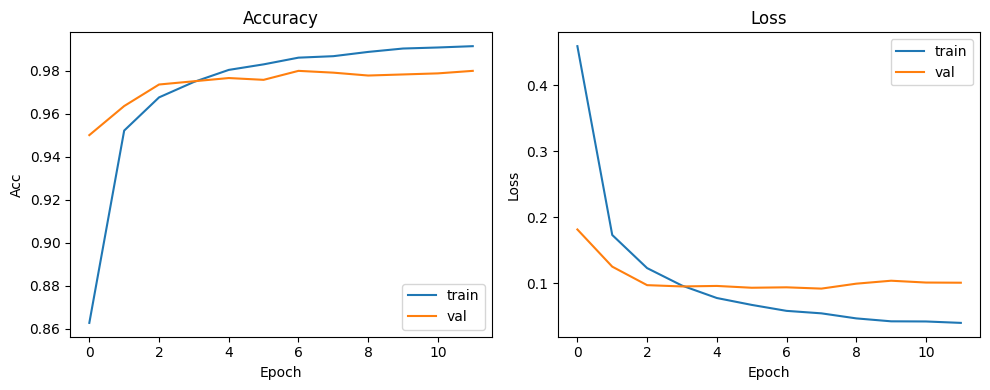

In [ ]:
# =============================================================================
# 6) Visualización: curvas de entrenamiento
# =============================================================================

import matplotlib.pyplot as plt

def plot_history(h):
    """
    Dibuja las curvas de accuracy y loss para train/val.
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(h.history["accuracy"], label="train")
    ax[0].plot(h.history["val_accuracy"], label="val")
    ax[0].set_title("Accuracy")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Acc")
    ax[0].legend()

    ax[1].plot(h.history["loss"], label="train")
    ax[1].plot(h.history["val_loss"], label="val")
    ax[1].set_title("Loss")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


## 7) Inspección de hiperparámetros elegidos

**Qué hace:**
 Lista los valores de hiperparámetros seleccionados por el proceso de sintonización y resume la configuración final del modelo.

**Para qué sirve:**

- Documenta la solución encontrada para reproducibilidad y auditoría.
- Facilita comparaciones entre ejecuciones y distintas estrategias de búsqueda.

**Cómo lo hace:**

- Itera sobre `best_hp.values` e imprime pares clave–valor ordenados.
- Complementa con el resumen del tuner (`results_summary`) para ver el ranking y métricas alcanzadas.

**Detalles importantes:**

- Guarda esta información junto con el modelo y las versiones de librerías para trazabilidad.
- Cambios en hardware o versiones de software pueden alterar los mejores hiperparámetros; mantener semilla y configuración del tuner ayuda a la consistencia.

**Definiciones:**

- Trazabilidad: capacidad de reconstruir el proceso y decisiones realizadas.
- Ranking: ordenamiento de configuraciones según su métrica objetivo.

In [ ]:
# =============================================================================
# 7) Inspección de hiperparámetros elegidos
# =============================================================================

print("Hiperparámetros finales seleccionados:")
for k in sorted(best_hp.values.keys()):
    print(f"  {k}: {best_hp.get(k)}")

Hiperparámetros finales seleccionados:
  activation: relu
  dropout: 0.2
  l2_reg: 6.1865755492251925e-06
  learning_rate: 0.00037154532388029995
  num_layers: 4
  units_0: 512
  units_1: 512
  units_2: 320
  units_3: 64


## Conclusiones

> Este es un ejemplo de cómo reportar resultados.<br>
> Los resultados mostrados pueden variar entre diferentes ejecuciones del Notebook.

**Objetivo:** optimizar una MLP para MNIST con Keras Tuner (comparó RandomSearch y BayesianOptimization).

**Tuner elegido:** BayesianOptimization (mejor val_accuracy que RandomSearch: Val acc 0.9833 vs 0.9803; Val loss 0.0899 vs 0.1526).

**Mejores métricas:**
Mejor `val_accuracy` alcanzada en validación: 0.983333349.

**Rendimiento en test con el modelo final:** loss = 0.0689, acc = 0.9826.

**Mejores hiperparámetros finales encontrados:**

- activation: relu
- dropout: 0.35
- l2_reg: 1.1554e-06
- learning_rate: 0.0010607864
- num_layers: 3
- units por capa: [256, 320, 384]


**Resumen de top trials (breve):**

- Trial 01 (mejor): `val_acc` 0.98333 — configuración arriba.

- Otros trials cercanos: `val_acc` entre 0.9813 y 0.9800 con variaciones en activation (elu/relu), dropout (0.1–0.3), learning_rate y tamaños de capa (128–512).


**Curvas de entrenamiento (observadas):**

- Precisión de entrenamiento y validación aumentan rápidamente en primeras 5–15 épocas; val_loss y train_loss descienden y luego se estabilizan.
- No hay evidencia clara de sobreajuste severo: `val_acc` y `train_acc` están cercanos (finales ~0.98).
